In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [4]:
rets

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0993,0.1152,0.1556,0.2302,0.0229,0.1385,-0.0010,0.2962,-0.0275,0.0090,-0.0180
2009-05-31,0.0585,0.1319,0.1594,0.0539,0.0279,0.0286,0.1627,0.0227,-0.0208,0.0537,0.0200
2009-06-30,-0.0007,-0.0140,-0.0225,0.0454,-0.0034,0.0335,-0.0263,-0.0249,-0.0056,0.0051,0.0020
2009-07-31,0.0746,0.1004,0.1101,0.1432,0.0153,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0369,0.0450,-0.0131,0.0334,-0.0042,-0.0170,-0.0404,0.1319,0.0076,0.0076,0.0084
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.0527,-0.0363,-0.0002,-0.0860,-0.0208,-0.0265,0.0789,-0.0823,-0.0211,-0.0262,-0.0206
2022-02-28,-0.0295,-0.0343,-0.0432,-0.0736,-0.0067,-0.0086,0.0647,-0.0459,-0.0030,-0.0112,0.0086
2022-03-31,0.0376,0.0052,-0.0338,-0.0077,-0.0026,-0.0129,0.0917,0.0686,-0.0406,-0.0422,-0.0188


MIN Correlation pair is ('DBC', 'IEF')
MAX Correlation pair is ('PSP', 'EFA')


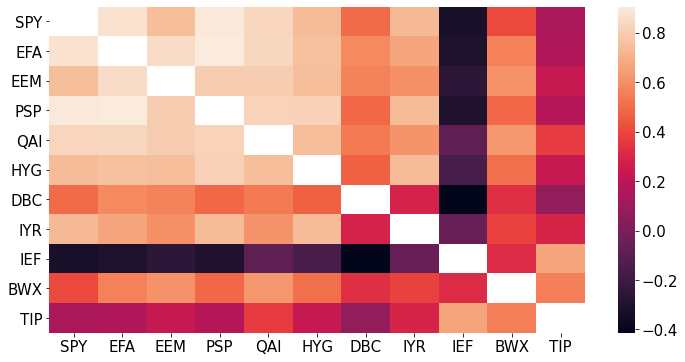

In [5]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

In [6]:
y = rets['PSP']
X_full = rets.drop(columns=['PSP'])
X_simple = rets[['SPY','TIP','IEF']]


X = X_full

mod = LinearRegression(fit_intercept=True).fit(X,y)

pe_replication = pd.DataFrame(index=X.columns, columns = ['beta'], data=mod.coef_)
pe_replication.T

,SPY,EFA,EEM,QAI,HYG,DBC,IYR,IEF,BWX,TIP
beta,0.4481,0.5608,-0.0237,0.2755,0.5297,-0.1236,0.0694,-0.5283,0.0492,0.3703


In [7]:
print(f'Regression R-squared is {mod.score(X,y):.1%}\n')
print(f'What is the correlation between the PE fund and the replicating portfolio?\n')

Regression R-squared is 89.8%

What is the correlation between the PE fund and the replicating portfolio?



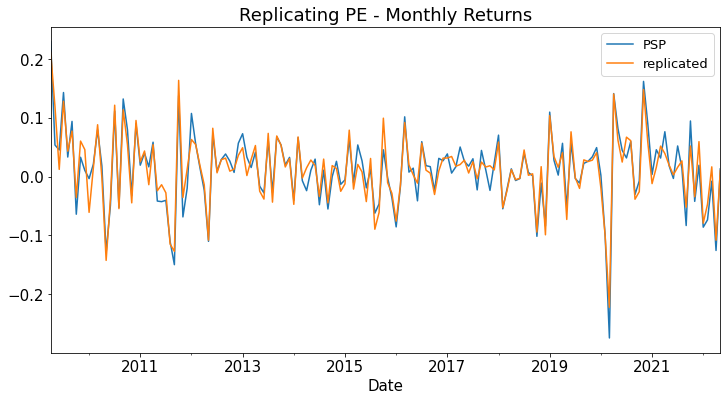

In [8]:
rets_replicated = pd.concat([y, pd.DataFrame(data=mod.predict(X),index=X.index, columns=['replicated'])],axis=1)
rets_replicated.plot(title='Replicating PE - Monthly Returns')
plt.show()

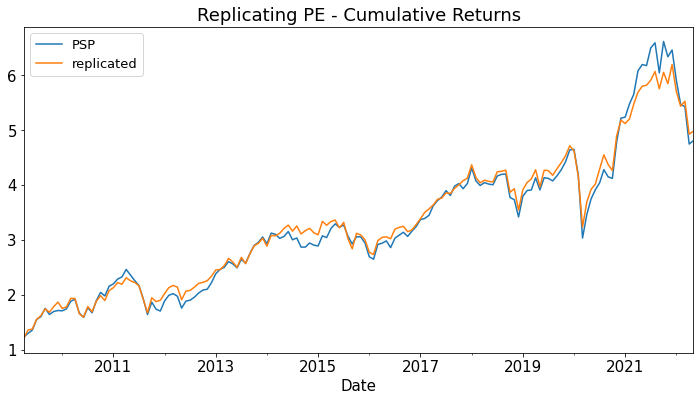

In [9]:
(rets_replicated+1).cumprod().plot(title='Replicating PE - Cumulative Returns')
plt.show()

In [10]:
X = X_simple
mod = LinearRegression(fit_intercept=True).fit(X,y)

pe_replication = pd.DataFrame(index=X.columns, columns = ['beta'], data=mod.coef_)
pe_replication.T

,SPY,TIP,IEF
beta,1.2897,0.6292,-0.4238


In [11]:
print(f'Regression R-squared is {mod.score(X,y):.1%}\n')
print(f'What is the correlation between the PE fund and the replicating portfolio?\n')

Regression R-squared is 81.4%

What is the correlation between the PE fund and the replicating portfolio?



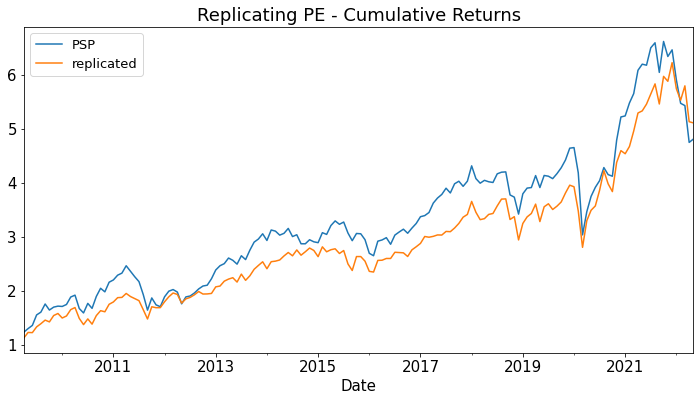

In [12]:
rets_replicated = pd.concat([y, pd.DataFrame(data=mod.predict(X),index=X.index, columns=['replicated'])],axis=1)
(rets_replicated+1).cumprod().plot(title='Replicating PE - Cumulative Returns')
plt.show()

# Appendix: Condition number of a matrix

$\newcommand{\olsb}{\boldsymbol{b}}$
$\newcommand{\olsy}{\boldsymbol{y}}$

Consider the linear equation

$$\olsy = a + X\olsb + e$$

Solving for $\olsb$,
$$(X'X)\olsb = X'\olsy$$

Denote the condition number of $X'X$ as $\kappa$.

Then,
$$\frac{||\delta \olsb||}{||\olsb||} \le \kappa \frac{||\delta X'\olsy||}{||X'\olsy||}$$

#### This says that 
- estimation error of size $\delta$ in the covariation of $X$ and $\olsy$ 
- will lead to errors up to size $\kappa\delta$ in the estimation of $\olsb$.

In [13]:
print(f'Condition Number FULL replication: {np.linalg.cond(X_full.T@ X_full):.1f}\n')
print(f'Condition Number SIMPLE replication: {np.linalg.cond(X_simple.T@ X_simple):.1f}')

Condition Number FULL replication: 321.3

Condition Number SIMPLE replication: 39.2


In [14]:
print(f'Determinant FULL replication: {np.linalg.det(X_full.T@ X_full):.6f}\n')

print(f'Determinant SIMPLE replication: {np.linalg.det(X_simple.T@ X_simple):.6f}')

Determinant FULL replication: 0.000000

Determinant SIMPLE replication: 0.000139
